<a href="https://colab.research.google.com/github/Is-Dani/Com470-DanitzaOrtizMorales/blob/main/puntos_referencia_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/IA3
# !pwd

/content/drive/MyDrive/IA3


In [9]:
# instalar dependencias
# !pip install -q --upgrade ipython==5.5.0
# !pip install -q --upgrade ipykernel==4.10
# !python -m pip install tensorflow-gpu==1.15
# !wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
# !dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
# !apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda=9.0.176-1
# import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'

In [3]:
# change makefile to have GPU, OPENCV and LIBSO enabled
!sed -i "s/GPU=0/GPU=1/g" darknet/Makefile
!sed -i "s/CUDNN=0/CUDNN=1/g" darknet/Makefile
!sed -i "s/CUDNN_HALF=0/CUDNN_HALF=1/g" darknet/Makefile
!sed -i "s/OPENCV=0/OPENCV=1/g" darknet/Makefile
!sed -i "s/LIBSO=0/LIBSO=1/g" darknet/Makefile

In [4]:
!head darknet/Makefile  

GPU=1
CUDNN=1
CUDNN_HALF=1
OPENCV=1
AVX=0
OPENMP=0
LIBSO=1
ZED_CAMERA=0
ZED_CAMERA_v2_8=0



In [5]:
!cd darknet; make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [6]:
%cd darknet/

/content/drive/My Drive/IA3/darknet


In [7]:
import dlib
predictor=dlib.shape_predictor("/content/drive/MyDrive/IA3/dlib/shape_predictor_68_face_landmarks.dat")

In [8]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline
 
 
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("/content/drive/MyDrive/IA3/Face_detection/cfg/yolov4-tiny-custom.cfg", "/content/drive/MyDrive/IA3/Face_detection/cfg/face.data", "/content/drive/MyDrive/IA3/Face_detection/cfg/pesos2/yolov4-tiny_final.weights")
width = network_width(network)
height = network_height(network)
 
# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)
 
  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height
 
  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
 
  free_image(darknet_image)
  return detections, width_ratio, height_ratio
 
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
 
  return img
 
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
 
  return bbox_bytes  
 
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
 
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
 
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
 
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
 
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
 
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
  
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    hg, wt, c = frame.shape
    # call our darknet helper on video frame
    detections, width_ratio, height_ratio= darknet_helper(frame, width, height)

    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      rect= dlib.rectangle(left,top,right,bottom)
      landmarks = predictor(frame, rect)

      for n in range(36, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        # bbox_array = cv2.circle(bbox_array, (x, y), 4, (255, 0, 0),4)
        bbox_array = cv2.circle(bbox_array, (x, y), 1, (255, 0, 0),2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)
      
 
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes    

<IPython.core.display.Javascript object>

In [11]:
def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear

[(308, 108) (566, 366)]


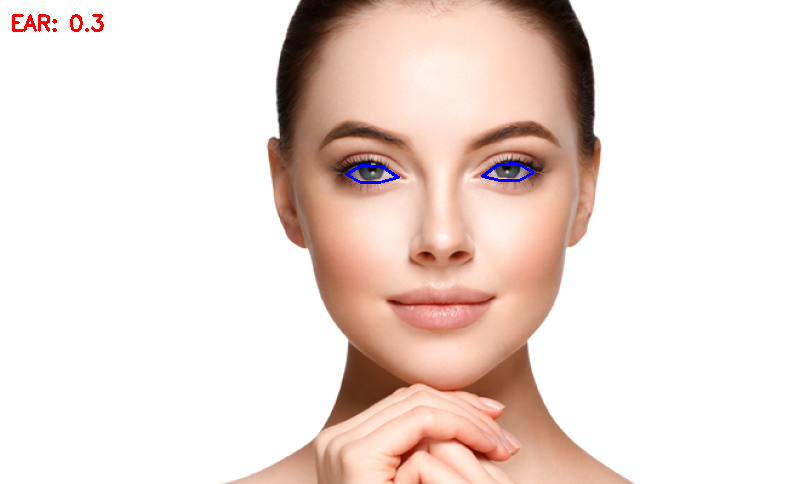

-1

In [10]:
import cv2
import dlib
import imutils
from imutils import face_utils
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow


#Global Configuration Variables
FACIAL_LANDMARK_PREDICTOR = "/content/drive/MyDrive/IA3/dlib/shape_predictor_68_face_landmarks.dat"  
# path to dlib's pre-trained facial landmark predictor
MINIMUM_EAR = 0.2    # Minimum EAR for both the eyes to mark the eyes as open


#Initializations
faceDetector = dlib.get_frontal_face_detector()
landmarkFinder = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)
# webcamFeed = cv2.VideoCapture(0)  
# faceDetector = predictor    
# print(faceDetector) 
# # dlib's HOG based face detector
# # dlib's landmark finder/predcitor inside detected face

# # Finding landmark id for left and right eyes
(leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]



def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear


image = cv2.imread("/content/drive/MyDrive/IA3/pruebas/82981-CARA.jpg")
image_h, image_w, c= image.shape
image = imutils.resize(image, width=800)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# rect= dlib.rectangle()

faces = faceDetector(grayImage, 0)
# faces = predictor.predict(grayImage, img_size=(192,192))

for face in faces:
   

    faceLandmarks = landmarkFinder(grayImage, face)
    faceLandmarks = face_utils.shape_to_np(faceLandmarks)

    leftEye = faceLandmarks[leftEyeStart:leftEyeEnd]
    rightEye = faceLandmarks[rightEyeStart:rightEyeEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0

    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)

    cv2.drawContours(image, [leftEyeHull], -1, (255, 0, 0), 2)
    cv2.drawContours(image, [rightEyeHull], -1, (255, 0, 0), 2)
    
    cv2.putText(image, "EAR: {}".format(round(ear, 1)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    if ear < MINIMUM_EAR:
        cv2.putText(image, "Drowsiness", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    print(face)

cv2_imshow( image)
cv2.waitKey(0)